# **Predicting Unemployment During Covid**
## Tim Hintz, Dan Valenzuela

***




## **Overview** <a id="Overview"></a>

In late 2019, the world was hit by the Sars-Covid-2. To prevent the spread of the disease, US state governments locked down the economy in March 2020. As a result of the pandemic, millions of people lost their jobs. The current research seeks to identify early signs that US households may lose their employment and in turn aid in the allocation of resources before the need is dire.


[**1. Business Problem**](#Business-Problem)

[**2. Data Understanding**](#Data-Understanding)

[**3. Data Preparation**](#Data-Preparation)

[**4. Data Analysis**](#Data-Analysis)

[**5. Evaluation**](#Evaluation)

[**6. Conclusion and Next Steps**](#Conclusion)
***

## **Business Problem** <a id="Business-Problem"></a>
[*↑ Back to overview*](#Overview)

Being able to predict which families and individuals are going to be in most dire need of financial assistence three months in advance will aid in providing the government with the necessary information for the distribution of relief funds. 

[*↑ Back to overview*](#Overview)
***

## **Data Understanding** <a id="Data-Understanding"></a>
[*↑ Back to overview*](#Overview)

### Current Population Survey

The data used in this model comes from the [Current Population Survey](https://www.census.gov/programs-surveys/cps/data/datasets.html) conducted by the U.S. Census Bureau. Each month the Census conducts a survey of 60,000 households and collects data on labor activity done in the past month. For the purposes of this project, we focused on households interviewed in April and July of 2020 which is the approximate range of dates that encapsulates the effects of coronavirus measures in the country, such as limited social activities. Further, although the dataset includes data about each individual in each household, we decided to keep adult individuals who were heads of household in April and July and were employed in April. Below is the resulting dataset using this filtering.

In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import dataloading as dl
from modules import VizFig as vf
from modules import VizAx as va

images_dir = 'src/images/'
data_targetdir = 'src/data/'
csv_targetdir = 'src/csv/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('src/csv/employed_adults_apr2020_jul2020.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 9 to 72340
Columns: 777 entries, HRHHID_x to IND_ID_FINAL_y
dtypes: int64(774), object(3)
memory usage: 23.6+ MB


In [4]:
df.head()

,HRHHID_x,HRMONTH_x,HRYEAR4_x,HURESPLI_x,HUFINAL_x,HETENURE_x,HEHOUSUT_x,HETELHHD_x,HETELAVL_x,HEPHONEO_x,...,PTNMEMP1_y,PEPDEMP2_y,PTNMEMP2_y,PECERT1_y,PECERT2_y,PECERT3_y,PXCERT1_y,PXCERT2_y,PXCERT3_y,IND_ID_FINAL_y
9,6006205110907,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,600620511090711011402311
18,7380717096190,4,2020,1,201,-1,1,2,2,0,...,-1,-1,-1,1,1,2,20,20,20,738071709619010111401531
33,33081904003391,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,3308190400339110011401531
46,60021870004061,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,2,-1,-1,20,0,0,6002187000406110111402351
62,89031522004171,4,2020,1,201,-1,1,1,-1,1,...,-1,-1,-1,1,1,2,20,20,0,8903152200417111011401411


With respect to our business question, the target variable of interest is `PREMPNOT` which takes on values in the range of 1 through 4, each representing whether a person is employed, unemployed, and not in the labor force for one of two reasons. Because we structured this data to include only those who are employed in April, looking at `PREMPNOT` for data from that month would only show that all rows take the value of 1 meaning they were all employed. As for July, below is the distribution of employment status among the population we selected, where "NILF" means "not in labor force".

<Figure size 432x288 with 0 Axes>

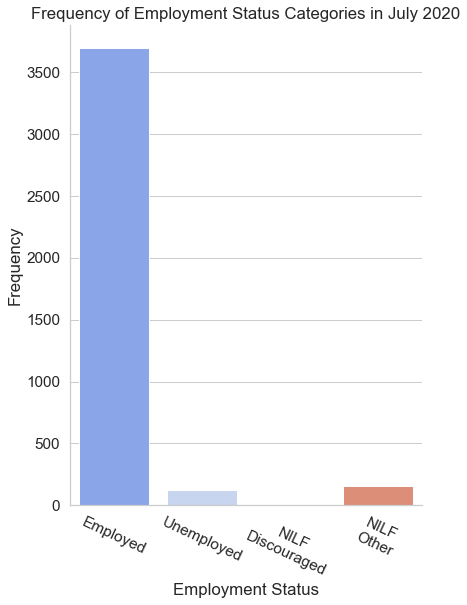

In [39]:
vf.PlotCat(df, xvar='PREMPNOT_y', targetdir=images_dir)

Further, as you can see above, there are over 300 features that are in each month's dataset recording a variety of demographic and labor data for each individual. For example, one can see in the graph below the number of males versus females in the dataset above. As one might expect, there is relative balance of males v. females in the population of employed heads of household with men outnumbering women slightly. Further, the distribution of age among this population is widespread with less frequency of young and older heads of household.

<Figure size 432x288 with 0 Axes>

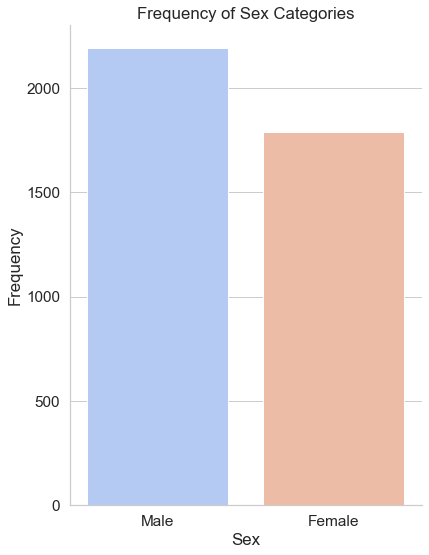

In [38]:
vf.PlotCat(df, 'PESEX_x', targetdir=images_dir)

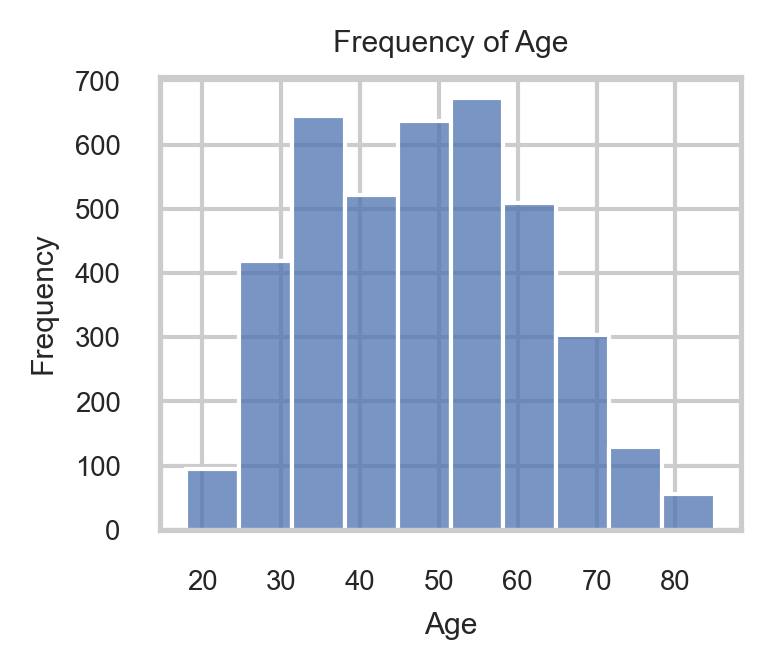

In [37]:
va.PlotHist(df, 'PRTAGE_x', targetdir=images_dir, bins=10)

For the sake of brevity, below is a list of all the features that were used in this dataset.

| Variable in CPS | Description| 
| --- | --- |
| HEHOUSUT | Type of housing | 
| GESTFIPS | State FIPS code |
| HEFAMINC | Family income |
| HRNUMHOU | Number of people in household |
| PRTAGE | Age of person |
| PEMARITL | Marital Status |
| PESEX | Sex of person |
| PEEDUCA | Level of education |
| PTDTRACE | Race composition of household |
| PEHSPNON | Hispanic status |
| PENATVTY | Born in US |
| PRCITSHP | Citizenship status |
| PRINUSYR | Immigrant's year of entry |
| PRHRUSL | Usual hours worked weekly |
| HUBUS | Ownership of business or farm in household |
| PEMJOT | More than 1 job or not |
| PEMJNUM | Num. of jobs if greater than 1|
| PEHRFTPT | Working more than 35 hours or not |
| PEHRRSN2 | Reasons for not working full-time |
| PEHRACTT | Number of hours worked in all jobs |
| PRAGNA | Works in agricultural industry? |
| PRNMCHILD | Number of children |
| PECYC | Number of college credit hours |
| PECERT1 | Professional certifi


### Political and Coronavirus Data

Political data came from a [kaggle](https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv) dataset that was scraped from the NYT API and was from the 2020 presidential election. We created a 'percent red' as a measure of how many Republicans are currently living in a given state. To supplement that information we scraped from wikipedia all the current Governers as an additional metric for political leaning.

Further, we collected data on covid prevalance from the [New York Times](https://github.com/nytimes/covid-19-data).



[*↑ Back to overview*](#Overview)
***

## **Data Preparation** <a id="Data-Preparation"></a>
[*↑ Back to overview*](#Overview)

### Current Population Survey

To prepare the data a few additional columns need to be generated in order to uniquely identify households and individuals. Households are uniquely identified by a concatenation of `HRHHID` and `HRHHID2` into `HH_ID`. Individuals, on the other hand, require a number of variables including `HH_ID`, age, and sex. The `clean_CPS_df` function below generates a unique identifier for individuals called `IND_ID_FINAL`.

In [ ]:
# # Un-comment to run

# apr_2020_df = dl.CPS_raw(targetdir, ['apr2020'], None)
# jul_2020_df = dl.CPS_raw(targetdir, ['jul2020'], None)

# apr_2020_df = c.clean_CPS_df(apr_2020_df)
# jul_2020_df = c.clean_CPS_df(jul_2020_df)

With both of these dataframes in hand, they need to be merged. We merged datasets from each month based on the `HH_ID` identifier as we want to be able to track individuals across April and July datasets.

In [ ]:
# # Un-comment to run
# merged = pd.merge(apr_2020_df, jul_2020, on=['HH_ID'], how='inner')

However, because this merge will still yield multiple individuals per household, the merged dataset is filtered down to adult heads of household who were employed in April. 

In [ ]:
# # Un-comment to run
# adult_emp = merged[(merged.PERRP_x.isin([40,41])) 
#                        & (merged.PRPERTYP_x == 2) 
#                        & (merged.PERRP_y.isin([40,41])) 
#                        & (merged.PREMPNOT_x.isin([1]))]

Further, because the merge may still keep duplicates, we dropped all duplicates of `HH_ID`. Since we filtered down to only adult heads of household, this will yield one individual per household.

In [ ]:
# # Un-comment to run
#  adult_emp = adult_emp.drop_duplicates(subset='HH_ID', keep='first')

Once all the above is run, you will return a dataframe that is equivalent to the dataframe imported from the CSV file above. Thus the dataframe `adult_emp` is equal to `df`. And you'll see that for every household there is one head of household. 

In [25]:
print(df.HH_ID.count())
print(df.IND_ID_FINAL_x.count())

3983
3983


Before this data can be used for analysis, each of the features above had to be binned or created into dummy variables in order to create an interpretable model.

With this dataset, this can finally be merged with political and coronavirus data according to the state that each individual belongs to. Further, this dataset is edited to ensure that only the target variable data from July is included and all the features are from April data.

In [42]:
df = pd.read_csv('src/csv/final_dataframe.csv')
df.head()

,HEHOUSUT,HWHHWGT,GTMETSTA,HEFAMINC,HRNUMHOU,HRHTYPE,PRTAGE,PEMARITL,PENATVTY,PRINUSYR,...,PEEDUCA_45,PEEDUCA_46,PTDTRACE_1,PTDTRACE_3,PEHSPNON_2,population,case_delta,party,percent_red,pop_density
0,1,40182430,1,16,3,1,31,1,1,0,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
1,1,26376142,1,15,3,1,53,1,1,0,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
2,1,37961372,1,13,3,1,53,1,1,0,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
3,1,38997054,1,15,4,1,35,1,1,0,...,0,0,0,0,1,4903185.0,57709.606452,1.0,62.087493,95.0
4,1,42003612,1,11,8,3,40,0,1,0,...,0,0,1,0,1,4903185.0,57709.606452,1.0,62.087493,95.0


[*↑ Back to overview*](#Overview)
***

## **Data Analysis** <a id="Data-Analysis"></a>
[*↑ Back to overview*](#Overview)

[*↑ Back to overview*](#Overview)
***

## **Evaluation**<a id="Evaluation"></a>
[*↑ Back to overview*](#Overview)

[*↑ Back to overview*](#Overview)
***

## **Conclusion and Next Steps**<a id="Conclusion"></a>
[*↑ Back to overview*](#Overview)

[*↑ Back to overview*](#Overview)
***